# **Ambiente**

## Install, Libs, Functions

In [8]:
#!pip install geopandas shapely matplotlib zipfile36 verde -q

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import shutil
import verde as vd
import requests

from shapely.geometry import Polygon


c:\Users\Luizemara\.conda\envs\mapas\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
#!pip install pystac-client pyproj rasterio -q

In [9]:
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from shapely.geometry import shape, Polygon, mapping

from pyproj import Transformer, CRS

import rasterio
from rasterio.plot import show
from rasterio.mask import mask

In [4]:
#!apt-get install -y gdal-bin python3-gdal
#!gdalinfo --version

In [ ]:
#!pip install planetary_computer -q

In [ ]:
#!pip install cmocean -q

In [10]:
import cmocean

###### Função para plotar 2 mapas do Brasil

In [7]:
def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.2, alpha=0.6)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=0.2, alpha=0.6)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

###### Haversine - distância em coordenadas lat long.

A fórmula Haversine pode ser usada para calcular a distância na esfera. Ela considera a curvatura da terra, mas pressupõe uma terra esférica em vez de um elipsoide. Para longas distâncias, a fórmula Haversine introduz um erro de menos de 0,1%. A altitude não é usada para calcular a distância. Mais em Microsoft Learn https://learn.microsoft.com/pt-br/dotnet/api/system.device.location.geocoordinate.getdistanceto?view=netframework-4.8.1

In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos em km usando a fórmula de Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Raio médio da Terra em km
    return km

###### Função para encontrar pontos dentro de uma janela de raio específico

In [9]:
# Função para encontrar pontos dentro de uma janela de raio específico
def find_neighbors(gdf, index, window_size_km):
    """Encontra todos os pontos dentro de uma janela de raio específico em km."""
    lon, lat = gdf.loc[index, ['LONGITUDE', 'LATITUDE']]
    distances = gdf.apply(lambda row: haversine(lon, lat, row['LONGITUDE'], row['LATITUDE']), axis=1)
    neighbors = gdf[distances <= window_size_km]
    return neighbors

###### Função plot gdf

In [20]:
def plot_gdf_scatter(x, y, c, cmap, title, centered_to_zero = 'no'):
    try:
      import cmocean
    except:
      %pip install cmocean -q
      import cmocean
    import numpy as np
    import matplotlib.pyplot as plt

    if centered_to_zero == 'no':
      vmin = np.min(c)
      vmax = np.max(c)
    elif centered_to_zero == 'yes':
      vmin = -np.max(c)
      vmax = np.max(c)
    else:
      print('centered_to_zero must be yes or no')
      return

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        x, y,
        c=c,
        cmap=cmap,
        s=2,
        alpha=0.8,
        linewidth=0,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.02)
    cbar.set_label(title)
    plt.grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    plt.show()

## Study area

### Coordinate system

In [5]:
from pyproj import CRS

# String do .prj
wkt_string = '''PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'''

# Criar o objeto CRS a partir do WKT
crs_projeto = CRS.from_wkt(wkt_string)

# Verificar o CRS
print(crs_projeto)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


### Area of interest

In [6]:
shapefile_path = "janela-ptrII_pg.shp"

#Criar polígono do entorno
aoi_gdf = gpd.read_file(shapefile_path)
aoi_gdf['geometry'] = aoi_gdf['geometry'].buffer(0) # corrige geometrias inválidas com buffer(0)
aoi_gdf = aoi_gdf[aoi_gdf.is_valid & (~aoi_gdf.is_empty)] # apagar feições que ainda estão inválidas

# Verificar CRS
if aoi_gdf.crs is None:
    aoi_gdf = aoi_gdf.set_crs(epsg=crs_projeto)
    print(f"CRS vazio. Definido {crs_projeto}.")
else:
    print(f"CRS original: {aoi_gdf.crs}")
    if aoi_gdf.crs.to_epsg() != crs_projeto:
        aoi_gdf = aoi_gdf.to_crs(epsg=crs_projeto)
        print("Reprojetado.")

CRS original: PROJCS["Polyconic_Brasil",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Polyconic"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-54],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [7]:
# Obter limites e montar objeto geoJSON
minx, miny, maxx, maxy = aoi_gdf.total_bounds
coords = [
    [minx, miny],
    [maxx, miny],
    [maxx, maxy],
    [minx, maxy],
    [minx, miny]   # fecha o poligono
]

aoi = {
    "type": "Polygon",
    "coordinates": [coords]
}

# Criar um polígono do entorno e exibir
aoi_polygon = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(index=[0], geometry=[aoi_polygon])
aoi_gdf = aoi_gdf.set_crs(crs_projeto, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
aoi_gdf.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title('Area of Interest (AOI)')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

NameError: name 'Polygon' is not defined

**Upload dos dados preparados na Etapa 1**

In [13]:
grav_gdf = gpd.read_file("grav_gdf_copernicus.gpkg")
print(grav_gdf.head())

    LATITUDE  LONGITUDE   GRAV_OBS  ALT_ORT       source_file  ALT_ORTCO  \
0 -11.186133 -62.155065  978167.79   238.14  bgi_20250221.zip        NaN   
1 -11.195567 -62.155110  978167.09   232.07  bgi_20250221.zip        NaN   
2 -11.205559 -62.154960  978168.31   214.83  bgi_20250221.zip        NaN   
3 -11.214858 -62.155118  978163.82   240.39  bgi_20250221.zip        NaN   
4 -11.221462 -62.161604  978165.31   218.33  bgi_20250221.zip        NaN   

                      geometry  
0  POINT (-62.15507 -11.18613)  
1  POINT (-62.15511 -11.19557)  
2  POINT (-62.15496 -11.20556)  
3  POINT (-62.15512 -11.21486)  
4   POINT (-62.1616 -11.22146)  


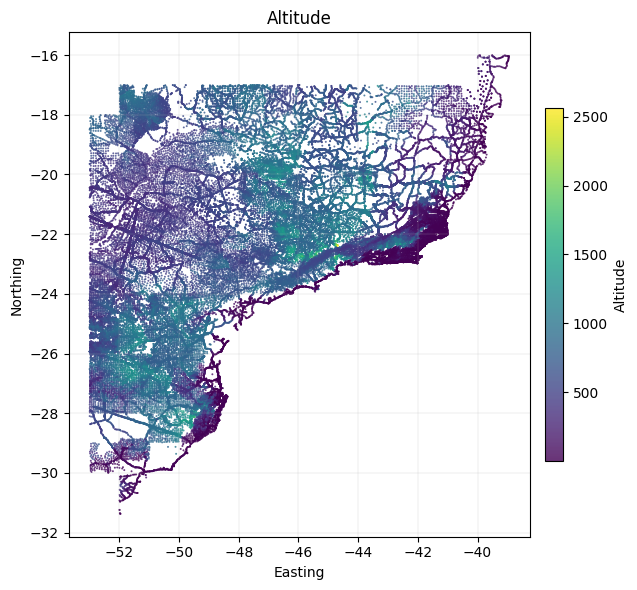

In [28]:
plot_gdf_scatter(grav_gdf.LONGITUDE, grav_gdf.LATITUDE, grav_gdf.ALT_ORTCO, 'viridis', 'Altitude', 'no')

In [25]:
print(f"Número de registros em grav_gdf é: {len(grav_gdf)}")

Número de registros em grav_gdf é: 237893


# **2. Redução dos dados**


## **2.1 Terrestrial Free-Air Anomaly**

#### **Orthometric Altitude (H)**

**Com o uso do Copernicus, não há o cálculo utilizando o geóide.**
O MDE COP-30 está referenciado em coordenadas geográficas WGS84 (datum horizontal) e altitude ortométrica referenciada ao modelo geoidal EGM2008 (datum vertical).

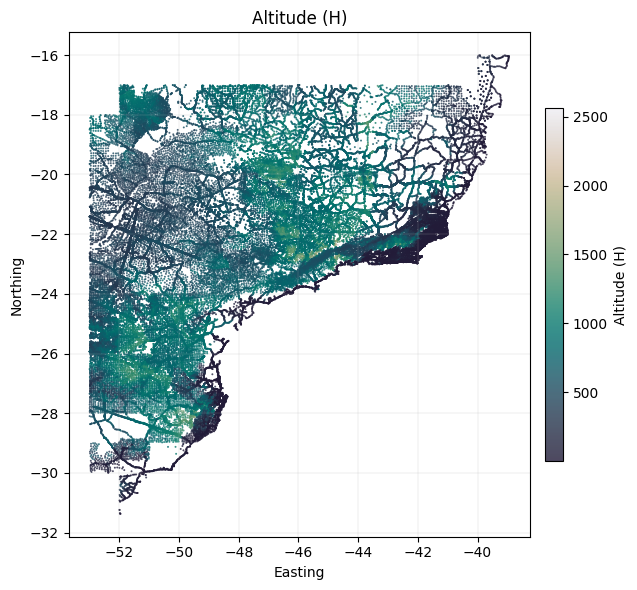

In [29]:
# Filtrar apenas registros com ALT_ORTCO numérico
mask = np.isfinite(grav_gdf["ALT_ORTCO"])
grav_gdf_plot = grav_gdf.loc[mask]

# Extrair coordenadas e valores
x = grav_gdf_plot.geometry.x.values
y = grav_gdf_plot.geometry.y.values
cop = grav_gdf_plot["ALT_ORTCO"].values  # altitude em metros

# Plot
plot_gdf_scatter(x=x, y=y, c=cop, cmap=cmocean.cm.rain_r, title="Altitude (H)")

In [30]:
# Altitude ortométrica H (m)
H = grav_gdf.loc[mask, "ALT_ORTCO"]

#### **Normal Gravity 𝛾(𝜑)**

A gravidade normal pode ser descrita como

$ γ(𝜑) = γe (1 + β sin²φ) $ *+ termos de ordem superior*

sendo γ a gravidade normal, γe a gravidade normal no equador, β um parâmetro que depende da forma da Terra e φ é a latitude.

Formula internacinal da gravidade (1980):

$ 𝛾(𝜑) = 978032.67715  *  (1 + 0.0052790414 sin²𝜑 + 0.0000232718  sin^4𝜑) $

Moritz, H. Geodetic reference system 1980. Bull. Geodesique 54, 395–405 (1980). https://doi.org/10.1007/BF02521480

In [31]:
# Calculo da Gravidade normal em mGal (GRS-80)
phi = np.deg2rad(grav_gdf.loc[mask, "LATITUDE"])
g_norm = 978032.67715 * ( 1 + 0.0052790414 * np.sin(phi)**2 - 0.0000232718 * np.sin(phi)**4)

#### **Free-Air Correction**

In [34]:
# Correção free-air: ΔgFA = 0.3086·H − 3.1·10⁻⁶·H²
g_FA = 0.3086 * H - 3.1e-6 * H**2

#### **Free-Air Anomaly (δgFA)**

In [35]:
# Anomalia free-air δgFA = g_obs − g_norm + ΔgFA
dg_FA = grav_gdf.loc[mask, "GRAV_OBS"] - g_norm + g_FA

In [38]:
# Adicionar colunas ao GeoDataFrame
grav_gdf.loc[mask, "FA_CORR"] = g_FA
grav_gdf.loc[mask, "FA"] = dg_FA
grav_gdf_onshore = grav_gdf.loc[mask, ["LATITUDE","LONGITUDE","GRAV_OBS", "ALT_ORTCO","FA_CORR","FA", "geometry"]]

# Salvar backup
#from google.colab import files  # Colab
grav_gdf_onshore.to_file("./grav_fa_onshore.gpkg", driver="GPKG")
#files.download('/content/grav_fa_onshore.gpkg')  # Colab

grav_gdf_onshore

,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORTCO,FA_CORR,FA,geometry
1208,-26.726082,-49.484579,978933.06,518.086182,159.049316,16.115110,POINT (-49.48458 -26.72608)
1209,-26.733934,-49.478549,978933.21,522.671387,160.449524,17.097782,POINT (-49.47855 -26.73393)
1210,-26.744365,-49.478098,978934.66,520.868408,159.898941,17.243218,POINT (-49.4781 -26.74436)
1211,-26.752794,-49.473389,978937.82,517.515625,158.875076,18.769859,POINT (-49.47339 -26.75279)
1212,-26.757917,-49.464726,978938.57,517.563477,158.889694,19.164027,POINT (-49.46473 -26.75792)
...,...,...,...,...,...,...,...
237888,-22.740000,-45.130000,978610.27,531.440735,163.127075,-30.243239,POINT (-45.1337 -22.7446)
237889,-22.770000,-45.150000,978612.64,537.578491,165.000854,-27.925433,POINT (-45.1492 -22.7687)
237890,-22.780000,-45.160000,978615.91,545.278625,167.351273,-22.947445,POINT (-45.1598 -22.7822)
237891,-22.800000,-45.170000,978623.15,541.261047,166.124969,-18.219265,POINT (-45.1732 -22.805)


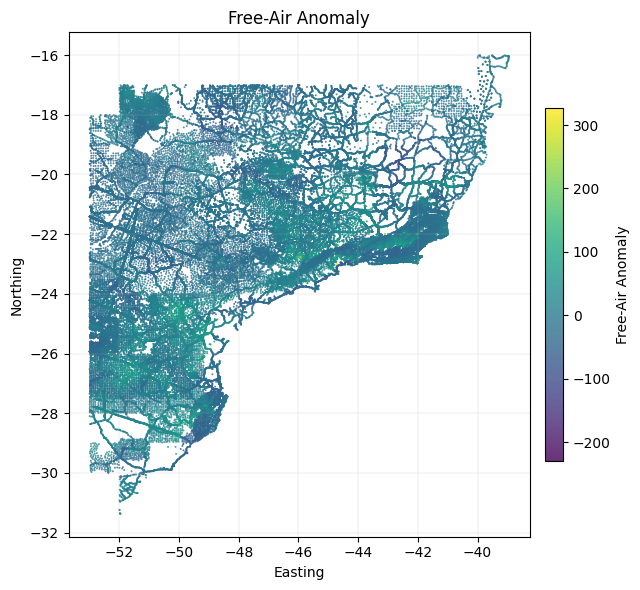

In [70]:
plot_gdf_scatter(x=grav_gdf_onshore["LONGITUDE"], y=grav_gdf_onshore["LATITUDE"], c=grav_gdf_onshore["FA"], cmap='viridis', title="Free-Air Anomaly", centered_to_zero='no')

#### Save file

In [ ]:
# Salvar grav_gdf_onshore como shapefile

base = './grav_gdf_onshore'
grav_gdf_onshore.to_file(f'{base}.shp')
for ext in ('shp','shx','dbf','prj'):
    path = f'{base}.{ext}'

In [ ]:
# Salvar GPKG

grav_gdf_onshore.to_file("./grav_fa_onshore.gpkg", driver="GPKG")

## **2.2 Marine Free-Air**

### **Free-air from Sandwell et al. 2014 (v32)**

In [44]:
import requests

url = "https://topex.ucsd.edu/pub/global_grav_1min/grav_32.1.nc"
filename = "grav_32.1.nc"

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Downloaded {filename} successfully.")

except requests.exceptions.RequestException as e:
    print(f"Error downloading {url}: {e}")

Downloaded grav_32.1.nc successfully.


In [18]:
import xarray as xr
# Open the netCDF file
sandwell_ds = xr.open_dataset("./grav_32.1.nc")
print("Vars:", list(sandwell_ds.data_vars))

Vars: ['z']


Windowing dataset

In [19]:
# Convert aoi_gdf to WGS84 geographic coordinates (EPSG:4326)
aoi_gdf_wgs84 = aoi_gdf.to_crs(epsg=4326)

# Keep only data within AOI bounds (WGS84)
minx, miny, maxx, maxy = aoi_gdf_wgs84.total_bounds
bat_margin = 1.2
ds_sub = sandwell_ds.sel(
    lon=slice(minx - bat_margin, maxx + bat_margin), # data margin
    lat=slice(miny -bat_margin, maxy + bat_margin),
)

df = ds_sub["z"].to_dataframe(name="FA").reset_index()

# Create the geometry field (WGS84)
sandwell_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

print("Grav records:", len(sandwell_gdf))

plot_gdf_scatter(x=sandwell_gdf["lon"], y=sandwell_gdf["lat"], c=sandwell_gdf["FA"], cmap=cmocean.cm.balance, title="FA Sandwell")

Grav records: 916104


NameError: name 'plot_gdf_scatter' is not defined

### **Obtaining high resolution bathymetry to join with offshore FA**

Read ASCII data from LEPLAC Project (Brazilian Navy) 

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np
import pandas as pd

'''# Carregar CSV
df = pd.read_csv("./bat.csv")

# Criar GeoDataFrame com CRS da projeção do projeto ############# policônica Sirgas 2000 (EPSG:5880)
bat_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X"], df["Y"]),
    crs=crs_projeto
)

bat_gdf.head()'''

df_bathymetry = pd.read_csv(
    './DTM_Brasil_LatLongProf/DTM_Brasil_MAR21_1000m.XYZ',
    sep='\s+', #delim_whitespace=True, # whitespace delimiter
    names=['LATITUDE', 'LONGITUDE', 'BAT']
)

# Create a GeoDataFrame
geometry = gpd.points_from_xy(df_bathymetry['LONGITUDE'], df_bathymetry['LATITUDE'])
gdf_bathymetry = gpd.GeoDataFrame(df_bathymetry, geometry=geometry, crs='EPSG:4326')

print("Batimetria GeoDataFrame criado:")
print(gdf_bathymetry.head())
print(gdf_bathymetry.crs)  # WGS 84 (World Geodetic System)

Batimetria GeoDataFrame criado:
    LATITUDE  LONGITUDE     BAT                     geometry
0 -37.499877 -47.475963 -5102.6  POINT (-47.47596 -37.49988)
1 -37.499877 -47.466980 -5102.7  POINT (-47.46698 -37.49988)
2 -37.499877 -47.457996 -5103.0    POINT (-47.458 -37.49988)
3 -37.499877 -47.449013 -5103.1  POINT (-47.44901 -37.49988)
4 -37.499877 -47.440030 -5103.5  POINT (-47.44003 -37.49988)
EPSG:4326


From ASCII to Raster

In [14]:
gdf_bathymetry = gdf_bathymetry.to_crs(crs_projeto)
print(gdf_bathymetry.crs)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


In [15]:
print(gdf_bathymetry.head())

    LATITUDE  LONGITUDE     BAT                         geometry
0 -37.499877 -47.475963 -5102.6  POINT (5576429.967 5828025.298)
1 -37.499877 -47.466980 -5102.7  POINT (5577222.398 5827970.243)
2 -37.499877 -47.457996 -5103.0  POINT (5578014.823 5827915.112)
3 -37.499877 -47.449013 -5103.1  POINT (5578807.242 5827859.906)
4 -37.499877 -47.440030 -5103.5  POINT (5579599.657 5827804.624)


In [16]:
# Limites da malha
minx, miny, maxx, maxy = gdf_bathymetry.total_bounds

# Resolucao do grid, e calcular largura e altura
res = 1000
width = int((maxx - minx) / res)
height = int((maxy - miny) / res)

# Definir a transformação affine
transform = from_origin(minx, maxy, res, res)

# Criar pares de (geometria, valor)
shapes = ((geom, value) for geom, value in zip(gdf_bathymetry.geometry, gdf_bathymetry["BAT"]))

# Rasterizar
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32"
)

# Salvar GeoTIFF
with rasterio.open(
    "./bat_brazil.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs=crs_projeto,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)

In [1]:
import geopandas as gpd
import rasterio
import numpy as np

dem_path = './bat_brazil.tif'

with rasterio.open(dem_path) as dem:
    dem_bat = dem.read(1)
    # Reproject grav GDF to raster CRS
    if sandwell_gdf.crs != dem.crs:
        sandwell_gdf = sandwell_gdf.to_crs(dem.crs)

    # Coorddinates with raster CRS
    coords = [(pt.x, pt.y) for pt in sandwell_gdf.geometry]
    # Sample DEM
    dem_vals = np.array([v[0] for v in dem.sample(coords)], dtype=np.float32)
    # From nodata to NaN
    if dem.nodata is not None:
        dem_vals[dem_vals == dem.nodata] = np.nan

print("Min value of DEM:", np.nanmin(dem_vals))
print("Max value of DEM:", np.nanmax(dem_vals))
print("Total of NaN values:", np.isnan(dem_vals).sum())

# Filtering where DEM <= 0
offshore_mask = dem_vals <= 0
sandwell_offshore_gdf = sandwell_gdf.loc[offshore_mask].copy()
sandwell_offshore_gdf["BAT"] = dem_vals[offshore_mask]



NameError: name 'sandwell_gdf' is not defined

In [29]:
print(f"Number of points in sandwell_offshore_gdf: {len(sandwell_offshore_gdf)}")
sandwell_offshore_gdf = sandwell_offshore_gdf.rename(columns={'lat': 'LATITUDE', 'lon': 'LONGITUDE'})
print(sandwell_offshore_gdf.columns)

Number of points in sandwell_offshore_gdf: 539935
Index(['LATITUDE', 'LONGITUDE', 'FA', 'geometry', 'BAT'], dtype='object')


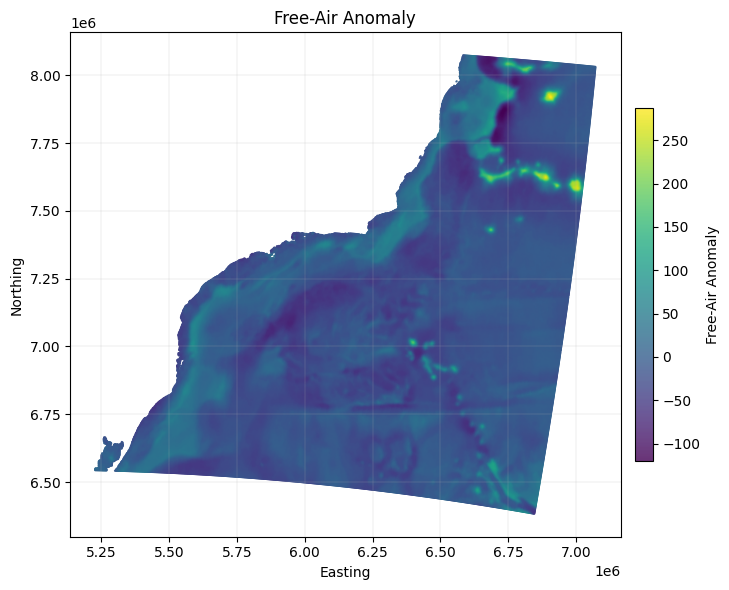

In [24]:
plot_gdf_scatter(x=sandwell_offshore_gdf.geometry.x, y=sandwell_offshore_gdf.geometry.y, c=sandwell_offshore_gdf["FA"], cmap='viridis', title="Free-Air Anomaly", centered_to_zero='no')

In [30]:
sandwell_offshore_gdf.head()

,LATITUDE,LONGITUDE,FA,geometry,BAT
37,-31.208333,-51.625000,18.532032,POINT (5226310.605 6543497.034),-3.9
38,-31.208333,-51.608333,14.369975,POINT (5227898.503 6543462.803),-4.2
39,-31.208333,-51.591667,9.570622,POINT (5229486.395 6543428.334),-4.5
40,-31.208333,-51.575000,6.086368,POINT (5231074.283 6543393.625),-4.6
41,-31.208333,-51.558333,5.576085,POINT (5232662.165 6543358.677),-4.9


In [31]:
# Salvar sandwell_offshore_gdf como shapefile

base = './grav_gdf_offshore'
sandwell_offshore_gdf.to_file(f'{base}.shp')
for ext in ('shp','shx','dbf','prj'):
    path = f'{base}.{ext}'

In [32]:
# Salvar GPKG
sandwell_offshore_gdf.to_file("./grav_fa_offshore.gpkg", driver="GPKG")